In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import EarlyStopping

In [2]:
symbol = "GOOGL"  # Google's stock symbol
start_date = "2015-01-01"
end_date = "2021-12-31"

data = yf.download(symbol, start=start_date, end=end_date)
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26.629999,26.790001,26.393999,26.477501,26.477501,26480000
2015-01-05,26.357500,26.399500,25.887501,25.973000,25.973000,41182000
2015-01-06,26.025000,26.060499,25.277500,25.332001,25.332001,54456000
2015-01-07,25.547501,25.574499,25.182501,25.257500,25.257500,46918000
2015-01-08,25.075500,25.375000,24.750999,25.345501,25.345501,73054000


In [3]:
scaler = MinMaxScaler()
data['Close_scaled'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))


In [4]:
sequence_length = 10

X, y = [], []

for i in range(len(data) - sequence_length):
    X.append(data['Close_scaled'].values[i:i+sequence_length])
    y.append(data['Close_scaled'].values[i+sequence_length])

X = np.array(X)
y = np.array(y)


In [5]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [10]:
# Reshape and normalize data
X_train = X_train.reshape(-1, sequence_length, 1).astype(np.float32)
y_train = y_train.astype(np.float32)

# Build and compile the RNN model
model = Sequential([
    SimpleRNN(units=50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    SimpleRNN(units=50, activation='relu', return_sequences=True),
    SimpleRNN(units=50, activation='relu'),
    Dense(units=1)
])

model.compile(optimizer='adam',loss='mse',metrics='mean_absolute_error')

# Train the model
callbacks = [EarlyStopping(monitor='loss',patience=10,restore_best_weights=True)]
model.fit(X_train, y_train, epochs=200, batch_size=32, callbacks=callbacks)


Epoch 1/200
44/44 [==============================] - 3s 11ms/step - loss: 0.0042 - mean_absolute_error: 0.0381
Epoch 2/200
44/44 [==============================] - 0s 10ms/step - loss: 1.4665e-04 - mean_absolute_error: 0.0086
Epoch 3/200
44/44 [==============================] - 0s 10ms/step - loss: 1.3258e-04 - mean_absolute_error: 0.0081
Epoch 4/200
44/44 [==============================] - 0s 10ms/step - loss: 1.1164e-04 - mean_absolute_error: 0.0075
Epoch 5/200
44/44 [==============================] - 0s 10ms/step - loss: 1.0675e-04 - mean_absolute_error: 0.0073
Epoch 6/200
44/44 [==============================] - 0s 11ms/step - loss: 8.8297e-05 - mean_absolute_error: 0.0066
Epoch 7/200
44/44 [==============================] - 0s 10ms/step - loss: 9.4885e-05 - mean_absolute_error: 0.0070
Epoch 8/200
44/44 [==============================] - 0s 11ms/step - loss: 8.8049e-05 - mean_absolute_error: 0.0065
Epoch 9/200
44/44 [==============================] - 0s 10ms/step - loss: 9.9180e-05

In [11]:
y_pred = model.predict(X_test)

11/11 [==============================] - 1s 6ms/step


In [12]:
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)

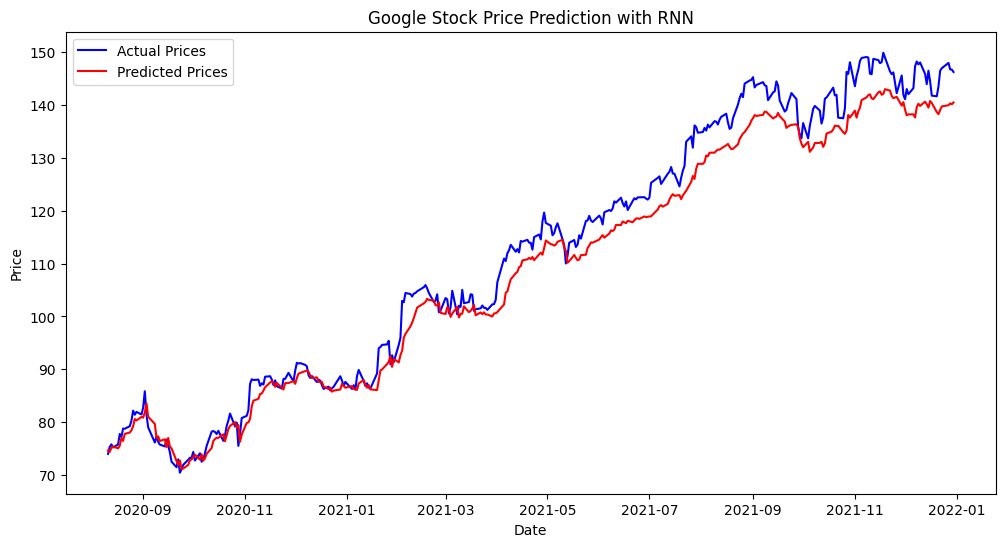

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size+sequence_length:], y_test_original, label='Actual Prices', color='blue')
plt.plot(data.index[train_size+sequence_length:], y_pred_original, label='Predicted Prices', color='red')
plt.title('Google Stock Price Prediction with RNN')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()